In [14]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
#jupyter内で画像を表示
%matplotlib inline 
#別ウィンドウで画像表示
# %matplotlib qt 
import csv
import json
from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display
import pathlib
# sigo_path = pathlib.Path('../../ns3.30/data/sigo/shutoushu-nodenum_900_seed_43222.csv')
sigo_path = pathlib.Path('../data/lsgo/0.1lsgo-nodenum_900_seed_43222.csv')
lsgo_path = pathlib.Path('../data/lsgo/6.0lsgo-nodenum_900_seed_43222.csv')

In [15]:
sigo_df = pd.read_csv(sigo_path)
lsgo_df = pd.read_csv(lsgo_path)
sigo_df.head()

,source_x,source_y,recv_x,recv_y,time,recv_priority,hopcount,recv_id,source_id,destination_id,destination_x,destination_y,pri_1,pri_2,pri_3,pri_4,pri_5
0,1498,1182,1487,1201,10000200,4,1,710,400,205,901,1542,98,344,227,811,710
1,1498,1182,1487,1201,10000200,3,1,811,400,205,901,1542,98,344,227,811,710
2,1498,1182,1475,1201,10000200,1,1,344,400,205,901,1542,98,344,227,811,710
3,1498,1182,1501,1239,10000200,2,1,227,400,205,901,1542,98,344,227,811,710
4,1498,1182,1438,1201,10000200,0,1,98,400,205,901,1542,98,344,227,811,710


In [16]:
sigo_df['destination_id'].value_counts().to_dict()

{11: 104,
 27: 19,
 36: 52,
 48: 86,
 80: 23,
 194: 54,
 198: 5,
 205: 6,
 234: 11,
 267: 19,
 331: 14,
 338: 184,
 353: 197,
 444: 212,
 469: 92}

In [17]:
dest_list = sigo_df['destination_id'].value_counts().index.tolist()
dest_list.sort()

In [18]:
sigo_reach_list = sigo_df[sigo_df['recv_id'] == sigo_df['destination_id']]['destination_id'].value_counts().index.tolist()
lsgo_reach_list = lsgo_df[lsgo_df['recv_id'] == lsgo_df['destination_id']]['destination_id'].value_counts().index.tolist()
sigo_reach_list.sort()
lsgo_reach_list.sort()

print('sigo:',sigo_reach_list)
print('lsgo:',lsgo_reach_list)

sigo: [27, 36, 48, 80, 194, 469]
lsgo: [48, 80, 194, 267, 331, 469]


In [19]:
def draw(log,count,img_area,protocol,text):
    if protocol == 'sigo':
        line_color = (0, 255, 0)
        thick = 9
        des_thick = 8
    else:
        line_color = (255, 0, 255)
        thick = 4
        des_thick = 4
    
    cv2.arrowedLine(img_area,(log.source_x, log.source_y), 
                            (log.recv_x, log.recv_y), line_color, thickness=thick, tipLength=0.15)
    cv2.circle(img=img_area, center=(log.source_x,
                           log.source_y), radius=10, color=(255,0,0), thickness=-1)
    cv2.circle(img=img_area, center=(log.recv_x,
                           log.recv_y), radius=10, color=(255,0,0), thickness=-1)
    #受け取ったのが宛先だったならば
    if log.recv_id == log.destination_id:
        cv2.drawMarker(img_area, (log.recv_x, log.recv_y), line_color, thickness=des_thick, markerType=cv2.MARKER_TILTED_CROSS, markerSize=25)
    if text == 'あり':    
        cv2.putText(img_area, str(log.source_id), (log.source_x + 10,log.source_y +10 ), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), thickness=2)
        cv2.putText(img_area, str(log.recv_id), (log.recv_x + 10,log.recv_y +10 ), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), thickness=2)
    if count == 1:
        #目的エリア描画
        #csvファイルに目的地の座標を加える
        cv2.rectangle(img_area, (log.destination_x - 15, log.destination_y - 15), (log.destination_x + 15, log.destination_y + 15), (255, 255, 0),thickness=8)
        #source nodeを視覚で囲む
        cv2.rectangle(img_area, (log.source_x - 15, log.source_y - 15), (log.source_x + 15, log.source_y + 15), (255, 255, 0),thickness=8)

        #方眼
        plt.figure(figsize=(20, 20))
        plt.grid(color='r', linestyle='dotted', linewidth=1.0)
        plt.xlim([-100, 2200])
        plt.xticks([2100,1800,1500,1200,900,600,300, 0]) 
        plt.ylim([-100, 2200])
        plt.yticks([0,300,600,900,1200,1500,1800,2100])  #メモリの間隔を指定 
    

lsgo: [48, 80, 194, 267, 331, 469]
sigo: [27, 36, 48, 80, 194, 469]


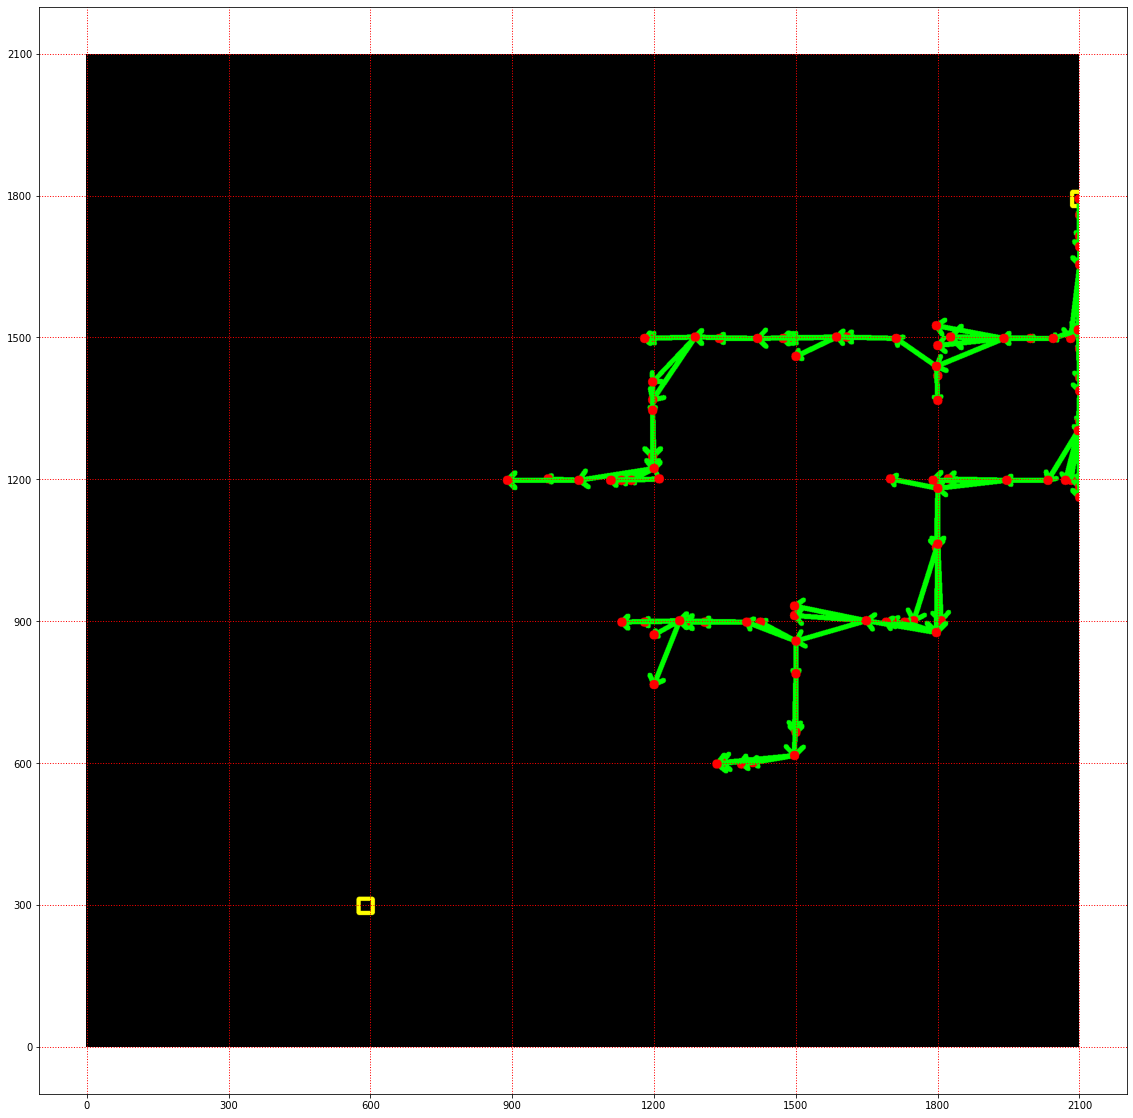

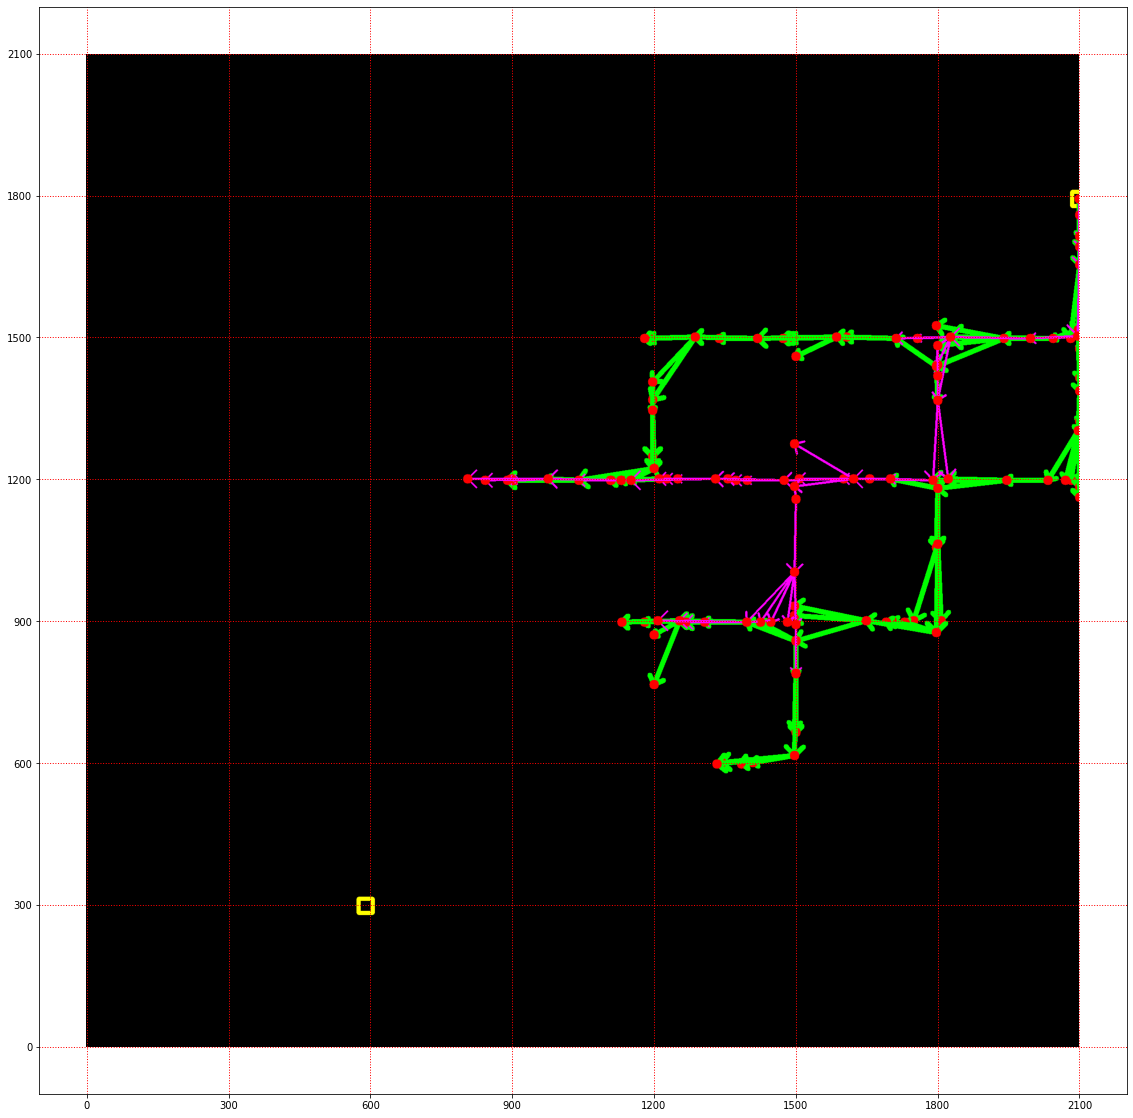

In [20]:
img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
protocol_list = ["sigo","lsgo", "both"]
text_list = ["なし", "あり"]
print('lsgo:',lsgo_reach_list)
print('sigo:',sigo_reach_list)

#packetの軌跡を描画 
@interact(minHop=(0,14,1), maxHop=(2,15, 1), desId=dest_list, protocol = protocol_list, text = text_list)
def packetDraw(protocol, desId, minHop=0, maxHop = 15, text = "なし"):
    img_area = np.zeros(shape=(2100,2100, 3), dtype=np.int16)
    count = 1
    if protocol == 'sigo':
        for log in sigo_df[sigo_df['destination_id'] == desId].itertuples():
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,protocol,text)
            count = count +1
        plt.imshow(img_area)
    elif protocol == 'lsgo':
        print('lsgo')
        for log in lsgo_df[lsgo_df['destination_id'] == desId].itertuples():
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,protocol,text)
            count = count +1
        plt.imshow(img_area)
    else:
        print('both')
        for log in sigo_df[sigo_df['destination_id'] == desId].itertuples():
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,'sigo',text)
            count = count +1
        for log in lsgo_df[lsgo_df['destination_id'] == desId].itertuples():
            if log.hopcount >= minHop and log.hopcount <= maxHop:
                draw(log,count,img_area,'lsgo',text)
        plt.imshow(img_area)
            